In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score,classification_report
from sklearn.model_selection import train_test_split
import shap
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Load the data
data = pd.read_csv('nearest-earth-objects.csv')

data.drop(columns=['name', 'orbiting_body','neo_id'], inplace=True) #not relevant columns as it consist of random names and orbiting body has only "earth" as data in all the rows.
# One-hot encode the 'is_hazardous' feature
data = pd.get_dummies(data, columns=['is_hazardous'], drop_first=True)

<ipython-input-5-d61c586a1432>:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('nearest-earth-objects.csv')


In [ ]:
# relevant features for scaling
features_to_scale = ['absolute_magnitude', 'estimated_diameter_min',
                     'estimated_diameter_max', 'relative_velocity', 'miss_distance']
scaler = StandardScaler()

# Fit and transform the features
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [ ]:
data['average_diameter'] = (data['estimated_diameter_min'] + data['estimated_diameter_max']) / 2 # creating new column to increase model performance

In [ ]:
# missing value check
missing_values = data.isnull().sum()
# Handling missing values
data.fillna(data.mean(), inplace=True)

In [ ]:
#features and target variable
X = data.drop(columns=['is_hazardous_True'])
y = data['is_hazardous_True']

EDA

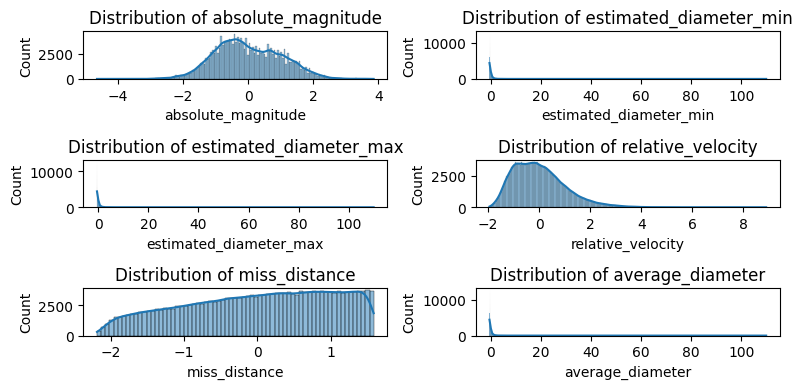

In [ ]:
# histograms
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 4))
for ax, column in zip(axes.flatten(), data.select_dtypes(include=['float64', 'int64']).columns):
    sns.histplot(data[column], ax=ax, kde=True)
    ax.set_title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

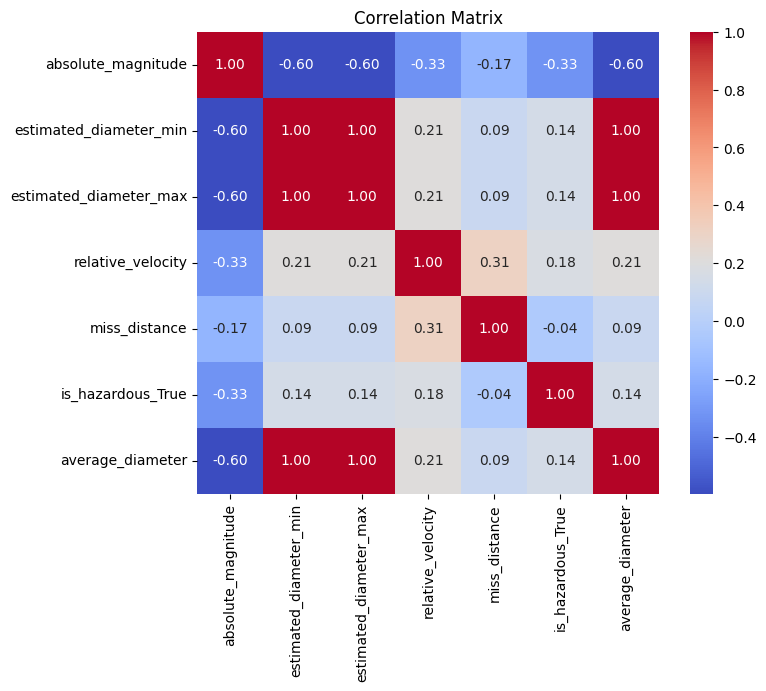

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

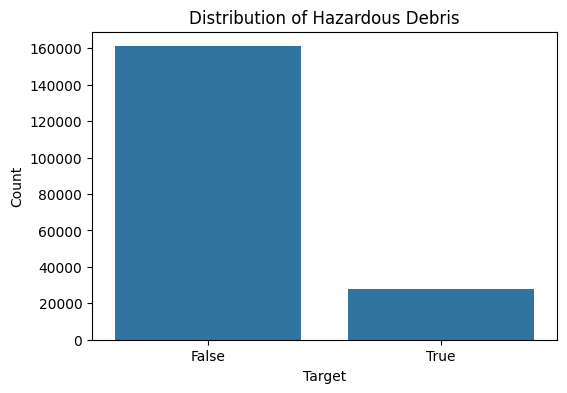

In [ ]:
y = data['is_hazardous_True']
# Plot target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Distribution of Hazardous Debris')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

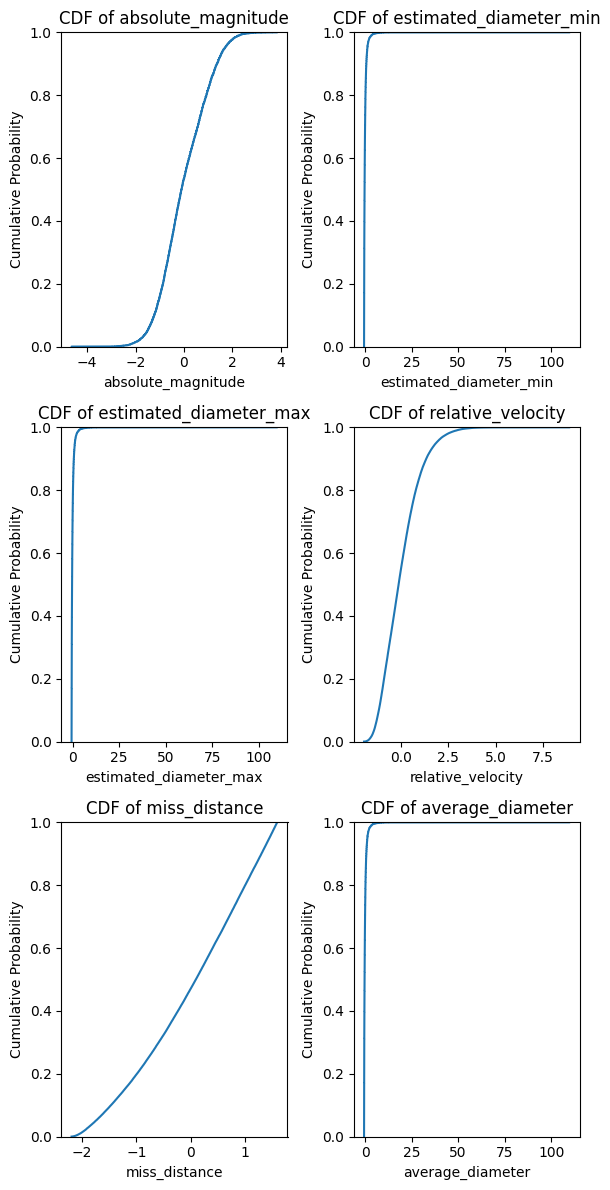

In [ ]:
# cumulative distribution functions
num_columns = len(data.select_dtypes(include=['float64', 'int64']).columns)
cols = 2  # Number of columns for subplots
rows = (num_columns + cols - 1) // cols  # number of rows needed

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(6, 4 * rows))
axes = axes.flatten()  # Flattening the array for indexing

# Looping through each column and create a CDF plot
for ax, column in zip(axes, data.select_dtypes(include=['float64', 'int64']).columns):
    sns.ecdfplot(data[column], ax=ax)
    ax.set_title(f'CDF of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Cumulative Probability')

for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

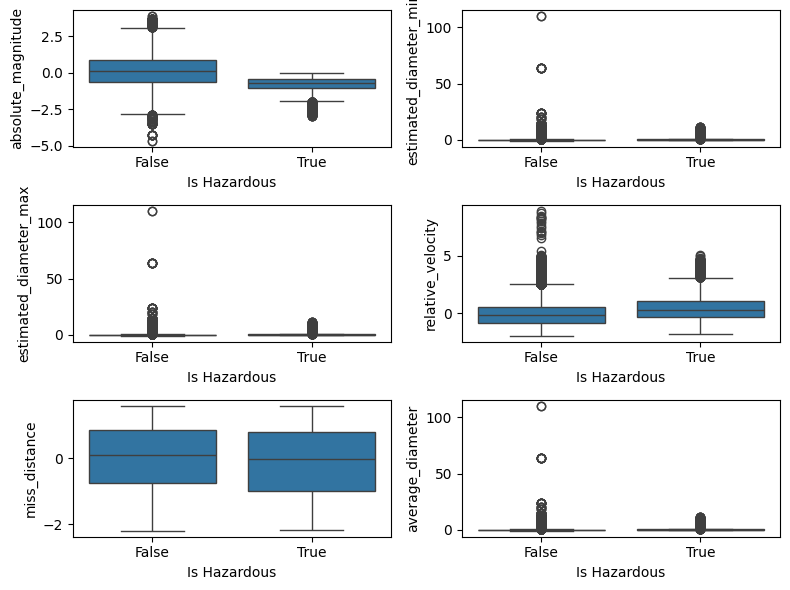

In [ ]:
# Box Plot
num_columns = len(data.select_dtypes(include=['float64', 'int64']).columns)
cols = 2  # columns
rows = (num_columns + cols - 1) // cols  #  number of rows

# Creating subplots
fig, axes = plt.subplots(rows, cols, figsize=(8, 2 * rows))
axes = axes.flatten()  # indexing

# Looping through each column
for ax, column in zip(axes, data.select_dtypes(include=['float64', 'int64']).columns):
    sns.boxplot(x='is_hazardous_True', y=column, data=data, ax=ax)
    ax.set_xlabel('Is Hazardous')
    ax.set_ylabel(column)

for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
# Split the resampled data into training and test sets
x_train, x_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Baseline LIGHTGBM without SMOTE

[LightGBM] [Info] Number of positive: 22130, number of negative: 128831
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 150961, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146594 -> initscore=-1.761567
[LightGBM] [Info] Start training from score -1.761567
Baseline Model (LightGBM Default) Performance Metrics:
Accuracy: 0.87
F1 Score (Positive Class): 0.33
F1 Score (Negative Class): 0.93
ROC AUC Score: 0.89
Confusion Matrix:
 [[31684   462]
 [ 4387  1208]]


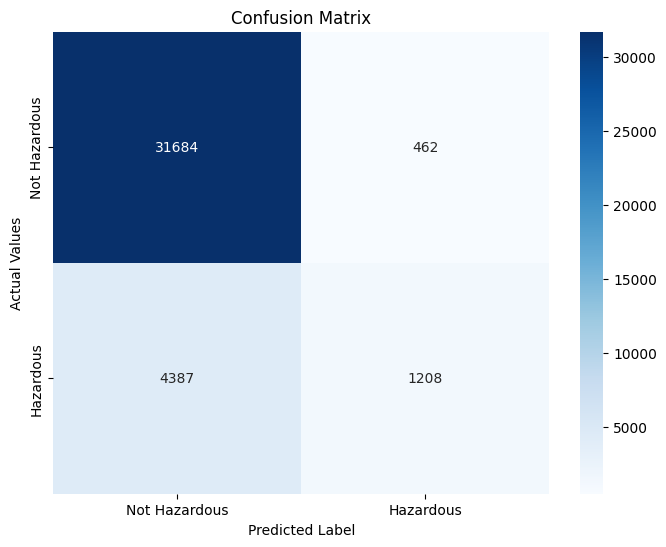

In [ ]:
import lightgbm as lgb
baseline_lgb_model_0 = lgb.LGBMClassifier ( num_leaves=50,learning_rate=0.05,n_estimators=200,max_depth=10,min_child_samples=20,subsample=0.8,colsample_bytree=0.8 )

# model fit
baseline_lgb_model_0.fit(x_train, Y_train)

#  TEST predictions
y_pred = baseline_lgb_model_0.predict(x_test)
y_pred_proba = baseline_lgb_model_0.predict_proba(x_test)[:, 1]

# Performance metrics
accuracy = accuracy_score(Y_test, y_pred)
f1_positive = f1_score(Y_test, y_pred, pos_label=1)  # F1 score for the positive class
f1_negative = f1_score(Y_test, y_pred, pos_label=0)  # F1 score for the negative class
roc_auc = roc_auc_score(Y_test, y_pred_proba)
conf_matrix = confusion_matrix(Y_test, y_pred)

# Print performance metrics
print("Baseline Model (LightGBM Default) Performance Metrics:")
print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score (Positive Class): {:.2f}".format(f1_positive))
print("F1 Score (Negative Class): {:.2f}".format(f1_negative))
print("ROC AUC Score: {:.2f}".format(roc_auc))
print("Confusion Matrix:\n", conf_matrix)

#confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Hazardous', 'Hazardous'],
            yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.99      0.93     32146
        True       0.72      0.22      0.33      5595

    accuracy                           0.87     37741
   macro avg       0.80      0.60      0.63     37741
weighted avg       0.86      0.87      0.84     37741



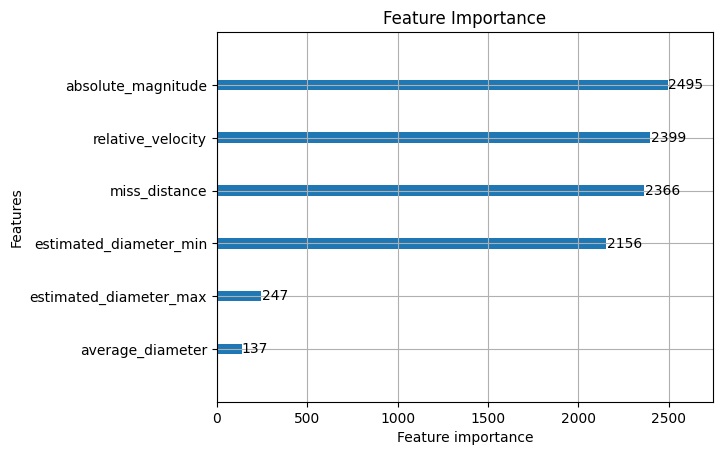

In [ ]:
# Feature Importance
lgb.plot_importance(baseline_lgb_model_0, max_num_features=10, importance_type='split', title='Feature Importance')
plt.show()

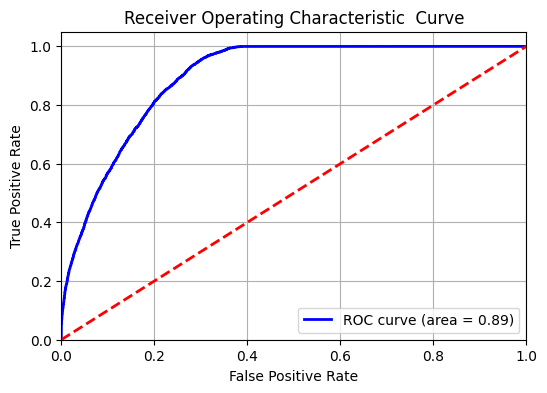

In [ ]:
from sklearn.metrics import  roc_auc_score, roc_curve, auc
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic  Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# class-imbalance problem

In [ ]:
# Checking if the distribution of the target variable are same
class_distribution = data['is_hazardous_True'].value_counts()
print(class_distribution)

is_hazardous_True
False    160977
True      27725
Name: count, dtype: int64


## Applying SMOTE

In [ ]:
# Separating features and target variable
X = data.drop(columns=['is_hazardous_True'])
y = data['is_hazardous_True']

# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# new class distribution
print(pd.Series(y_resampled).value_counts())

is_hazardous_True
False    160977
True     160977
Name: count, dtype: int64


In [ ]:
# Split the resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Baseline LightGBM using SMOTE

[LightGBM] [Info] Number of positive: 160977, number of negative: 160977
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 321954, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Baseline Model (LightGBM Default) Performance Metrics:
Accuracy: 0.83
F1 Score: 0.85
ROC AUC Score: 0.91


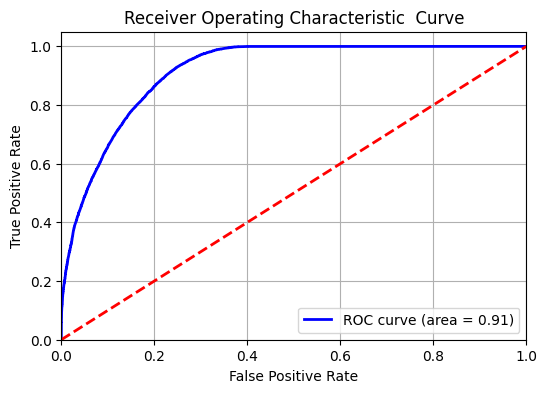

In [ ]:
import lightgbm as lgb
from sklearn.metrics import  roc_auc_score, roc_curve, auc
baseline_lgb_model = lgb.LGBMClassifier ( num_leaves=50,learning_rate=0.05,n_estimators=200,max_depth=10,min_child_samples=20,subsample=0.8,colsample_bytree=0.8 )

# model fit
baseline_lgb_model.fit(X_resampled, y_resampled)

#  TEST predictions
y_pred = baseline_lgb_model.predict(X_test)
y_pred_proba = baseline_lgb_model.predict_proba(X_test)[:, 1]

# performance metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Baseline Model (LightGBM Default) Performance Metrics:")
print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("ROC AUC Score: {:.2f}".format(roc_auc))

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic  Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
f1_positive = f1_score(y_test, y_pred, pos_label=1)  # F1 score for the positive class (1)
f1_negative = f1_score(y_test, y_pred, pos_label=0)  # F1 score for the negative class (0)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Baseline Model (LightGBM Default) Performance Metrics:")
print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score for Positive Class (1): {:.2f}".format(f1_positive))
print("F1 Score for Negative Class (0): {:.2f}".format(f1_negative))
print("ROC AUC Score: {:.2f}".format(roc_auc))
print("Confusion Matrix:\n", conf_matrix)

Baseline Model (LightGBM Default) Performance Metrics:
Accuracy: 0.83
F1 Score for Positive Class (1): 0.85
F1 Score for Negative Class (0): 0.80
ROC AUC Score: 0.91
Confusion Matrix:
 [[21920 10267]
 [  612 31592]]


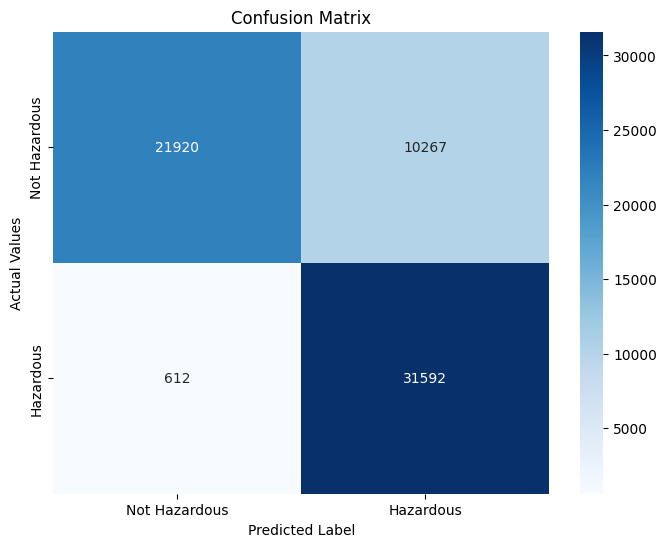

In [ ]:
#confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Hazardous', 'Hazardous'],
            yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.68      0.80     32187
        True       0.75      0.98      0.85     32204

    accuracy                           0.83     64391
   macro avg       0.86      0.83      0.83     64391
weighted avg       0.86      0.83      0.83     64391



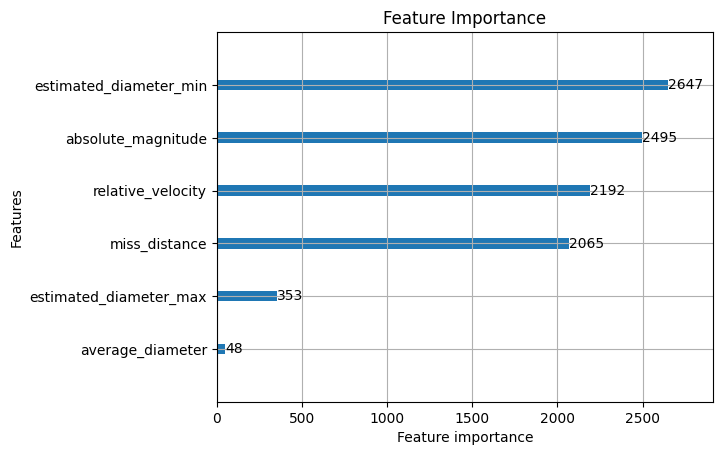

In [ ]:
# Feature Importance
lgb.plot_importance(baseline_lgb_model, max_num_features=10, importance_type='split', title='Feature Importance')
plt.show()

[LightGBM] [Info] Number of positive: 128773, number of negative: 128790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 257563, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499967 -> initscore=-0.000132
[LightGBM] [Info] Start training from score -0.000132
Best Parameters for LightGBM: {'num_leaves': 50, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1}
Best F1 Score (from CV): 0.8620182450126407
Test Set Metrics:
Accuracy: 0.84
F1 Score (Positive Class): 0.86
F1 Score (Negative Class): 0.82
ROC AUC Score: 0.93
Confusion Matrix:
 [[23224  8963]
 [ 1020 31184]]


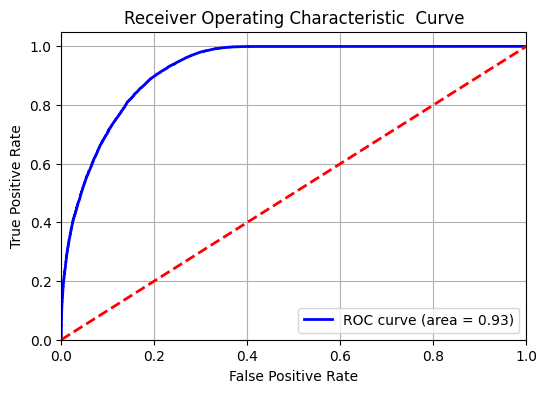

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# LightGBM model
lgb_model = lgb.LGBMClassifier()

# Parameter distribution for tuning
param_dist = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20]
}

# Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings to sample
    cv=4,
    scoring='f1',
    n_jobs=-1,
    random_state=42  # For reproducibility
)

# Fit the model
random_search.fit(X_train, y_train)

# Use the best estimator to make predictions on the test set
best_lgb_model = random_search.best_estimator_
y_pred = best_lgb_model.predict(X_test)
y_pred_proba = best_lgb_model.predict_proba(X_test)[:, 1]


# Calculate F1 scores for positive and negative classes
f1_positive = f1_score(y_test, y_pred, pos_label=1)  # F1 score for positive class
f1_negative = f1_score(y_test, y_pred, pos_label=0)  # F1 score for negative class
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_lgb_model.predict_proba(X_test)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred)

# Print performance metrics
print("Best Parameters for LightGBM:", random_search.best_params_)
print("Best F1 Score (from CV):", random_search.best_score_)
print("Test Set Metrics:")
print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score (Positive Class): {:.2f}".format(f1_positive))
print("F1 Score (Negative Class): {:.2f}".format(f1_negative))
print("ROC AUC Score: {:.2f}".format(roc_auc))
print("Confusion Matrix:\n", conf_matrix)
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic  Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

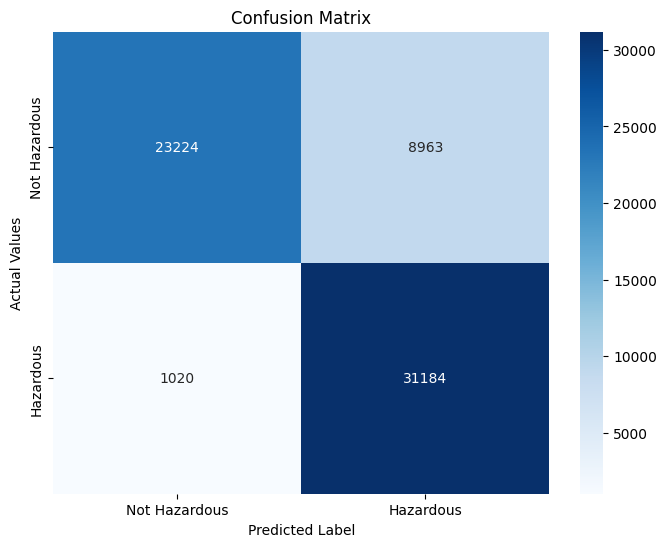

In [ ]:
#confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Hazardous', 'Hazardous'],
            yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.72      0.82     32187
        True       0.78      0.97      0.86     32204

    accuracy                           0.84     64391
   macro avg       0.87      0.84      0.84     64391
weighted avg       0.87      0.84      0.84     64391



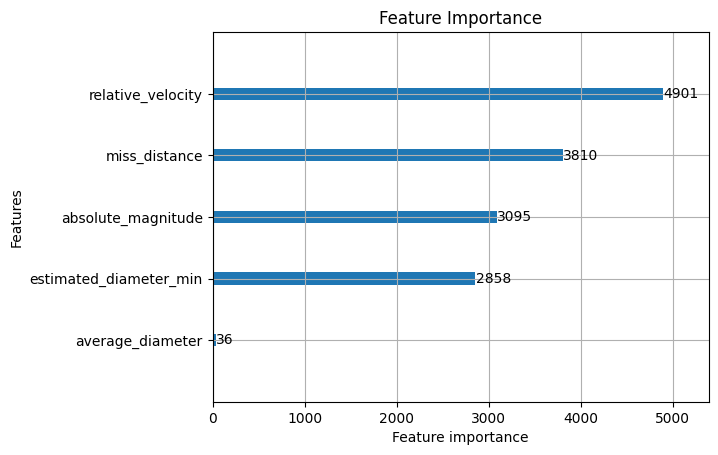

In [ ]:
# Feature Importance
lgb.plot_importance(best_lgb_model, max_num_features=10, importance_type='split', title='Feature Importance')
plt.show()

# SHAP value of each feature

In [ ]:
import shap
explainer = shap.Explainer(best_lgb_model)
shap_values = explainer(X_test)

# SHAP values
shap.summary_plot(shap_values, X_test)

NameError: name 'best_lgb_model' is not defined

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Hazardous', 'Hazardous'],
            yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# feature importance
lgb.plot_importance(best_lgb_model, max_num_features=10, importance_type='split', title='Feature Importance')
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_lgb_model, X_train, y_train, cv=5)

# mean and std for training and test scores
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score')
plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.show()

# Comparison between Baseline lightgbm and after hyperparameter

In [ ]:
# Baseline Model Metrics
baseline_accuracy = accuracy_score(y_test, baseline_lgb_model.predict(X_test))
baseline_f1 = f1_score(y_test, baseline_lgb_model.predict(X_test))
baseline_roc_auc = roc_auc_score(y_test, baseline_lgb_model.predict_proba(X_test)[:, 1])

# randomsearch Model Metrics
grid_accuracy = accuracy_score(y_test, grid_lgb.best_estimator_.predict(X_test))
grid_f1 = f1_score(y_test, grid_lgb.best_estimator_.predict(X_test))
grid_roc_auc = roc_auc_score(y_test, grid_lgb.best_estimator_.predict_proba(X_test)[:, 1])

#DataFrame to store the results
results = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'ROC AUC'],
    'Baseline': [baseline_accuracy, baseline_f1, baseline_roc_auc],
    'Grid Search': [grid_accuracy, grid_f1, grid_roc_auc]
})
print(results)

# Plotting the comparison
results.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Baseline and Grid Search LightGBM Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.show()